## __How to deal with probability distribution in DL:__
<font size=3>

Here, we are going to learn:
* How to encoding data labels into probability distributions;
* How the NN model outputs a probability distribution;
* Which loss function optimizes probability distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, activations, losses

2024-11-14 12:24:12.242003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 12:24:13.653955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### __1. How to encoding data labels into probability distributions:__
<font size=3>
    
Let's consider a supervised regression task using the classical [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits. The data is available in the [Keras dataset](https://keras.io/api/datasets/mnist/).  

x-train:(60000, 28, 28), y-train:(60000,)
x-test:(10000, 28, 28), y-test:(10000,)


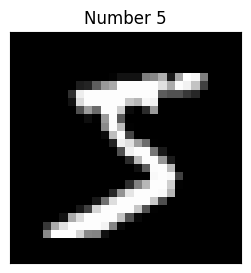

In [2]:
# import MNIST data:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data(path="mnist.npz")

print(f"x-train:{x_train.shape}, y-train:{y_train.shape}")
print(f"x-test:{x_test.shape}, y-test:{y_test.shape}")

# visualizing handwritten digits:
i = 0

plt.figure(figsize=(5,3))
plt.title("Number "+str(y_train[i]))
plt.imshow(x_train[i], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

#### __One-hot encoding:__
<font size=3>
    
One-hot encoding is a technique for multiclass data numerical encoding, such as the digit's labels $(0,1,2,3,4,5,6,7,8,9)$. It involves representing a label as the maximum probability in a vector with the same size as the number of classes. This means the label is assigned a vector position with a probability of 1, while the coefficients of the other vectors receive a probability of 0.

$0:(1,0,0,0,0,0,0,0,0,0);\; 1: (0,1,0,0,0,0,0,0,0,0);\; \cdots;\; 9: (0,0,0,0,0,0,0,0,0,1)$

For digit $\mathbf 3$, the model can output $(2.4,6.2,1.2,\mathbf{9.6},0.8,4.7,3.1,1.7,5.3,4.3)$.

We can use TensorFlow's [one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) function to do the encoding, or we can do it by "hand" as following.

In [3]:
# one-hot encoding for label data:

def one_hot(labels):
    N = labels.size
    
    y_hot = np.zeros((N, 10), dtype="float32")
    
    for i, y in enumerate(labels):
        y_hot[i][y] = 1

    return y_hot

print("After one-hot y-train(0:4) =\n", y_train[:4], "\n")

y_train = one_hot(y_train)

print("Before one-hot y-train(0:4) =\n", y_train[:4], "\n")


After one-hot y-train(0:4) =
 [5 0 4 1] 

Before one-hot y-train(0:4) =
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] 



### __2. How the NN model outputs a probability distribution:__
<font size=3>

When the model needs a probability distribution output vector, we use the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) to range the values in the interval $[0,\,1]$ and sum  to $1$, given by
$$
    \sigma_l(\vec a_l) = \frac{e^{a_l^i}}{\sum_{j=1} e^{a_l^j}} \, .
$$

2024-11-14 12:24:16.309555: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


min = 0.00, max = 0.02, sum = 1.00


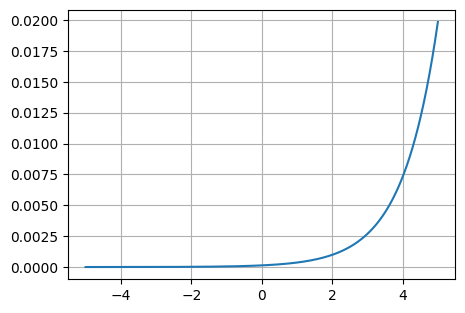

In [4]:
x = np.linspace(-5, 5, 500)

σ = activations.softmax(x)

print(f"min = {np.min(σ):.2f}, max = {np.max(σ):.2f}, sum = {np.sum(σ):.2f}")

plt.figure(figsize=(5, 3.5))
plt.plot(x, σ)
plt.grid()
plt.show()

<font size=3>

Note: In the example above, the exponential function allows us to distinguish the normalization of two vectors based on the same scale factor.

In [5]:
# comparing softmax with standard normalization:
def norm(x):
    return x/np.sum(x)

v1 = np.array([3.0, 6.0])
v2 = np.array([6.0, 12.0])

print(f"norm([3, 6]) = {norm(v1)}, norm([6, 12]) = {norm(v2)}\n")
print(f"softmax([3, 6]) = {activations.softmax(v1)}, softmax([6, 12]) = {activations.softmax(v2)}")

norm([3, 6]) = [0.33333333 0.66666667], norm([6, 12]) = [0.33333333 0.66666667]

softmax([3, 6]) = [0.04742587 0.95257413], softmax([6, 12]) = [0.00247262 0.99752738]


### __3. Which loss function optimizes probability distributions.:__
<font size=3>

For loss function optimization, the [Cross-Entropy function](https://en.wikipedia.org/wiki/Cross-entropy) can be used to handle probability distributions. It measures the match between the predicted distribution $q$ and the true distribution $p$, 
$$
    H(p,\,q) = -\sum_i p_i\,\ln q_i \, .
$$

In Keras, we have a [list of probability losses](https://keras.io/api/losses/) where the [categorical cross-entropy loss](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) is best suited to dealing with multiclass one-hot labels.

In [6]:
p = np.array([0.0, 1.0, 0.0, 0.0])

q1 = np.array([0.8, 5.5, 5.2, 2.3])
q2 = np.array([0.0, 9.5, 3.2, 0.1])

H1 = losses.CategoricalCrossentropy()(p, q1)
print("H1 (great disorder) =", H1)

H2 = losses.CategoricalCrossentropy()(p, q2)
print("H2 (small disorder) =", H2) 

H1 (great disorder) = tf.Tensor(0.9199205, shape=(), dtype=float32)
H2 (small disorder) = tf.Tensor(0.29815337, shape=(), dtype=float32)


### __Reference__:
<font size=3>
    
* [Softmax activation function: how it actually works](https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78);
* [Cross-entropy loss function](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e).